In [1]:
from Utils.loadset import getDataSet
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_probability as tfp
import os
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices)) 

from trainer import Trainer
try:
    from Utils.connection_cfg import *
except Exception as e:
    PSWD = None
    USRN = None
    
from Utils.Data import dataWrapper, provideData
from Utils.transform import cutOut, LinearMapping


tfd = tfp.distributions
def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)

Num GPUs: 1
Num GPUs Available: 1


Using TensorFlow backend.


In [2]:
dimension = (128,128)
channels = 7

slices = [400,528,400,528]
slices_label = [32,64+32,32,64+32]
cutOutFrame = cutOut(slices)
linearmap = LinearMapping()
cutOutFrame_label = cutOut(slices_label)
years = [2017]
PRETRAINING_TRANSFORMATIONS = [cutOutFrame]
TRANSFORMATION = [cutOutFrame_label,linearmap]
batch_size = 200

train, test = provideData(dimension=dimension,
                          batch_size=batch_size,
                          channels = channels,
                          timeToPred = 5,
                          onlyUseYears=[2017],
                          transform=TRANSFORMATION,
                          preTransformation=PRETRAINING_TRANSFORMATIONS)

Found Year :  2017 => won't download this year again... please check for consistency
Finished Loading Dataset
 
[DEBUG] Data
[DEBUG] time to predict:  5
SORTTING OUUUT 30796
[DEBUG] Data
[DEBUG] time to predict:  5
SORTTING OUUUT 13325


/home/simon/Dokumente/Teamprojekt/DeepRain2/Networks/Utils/transform.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return img[self.slices]


0.1


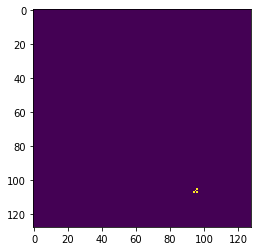

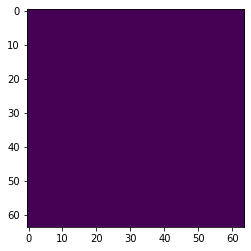

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure

x,y = train[10]
print(x[0].max())

plt.imshow(x[0,:,:,-1]*10)
plt.show()
plt.imshow(y[0,:,:,-1]*10)
plt.show()

In [4]:
"""
import cv2 as cv
import numpy as np
windowname = 'OpenCvFrame'
cv.destroyAllWindows()
cv.namedWindow(windowname)
cv.moveWindow(windowname,0,0)

for x,y in train:
    label = y
    print(x.shape,y.shape)
    batchsize = x.shape[0]
    for i in range(batchsize):
        z = np.ones((x.shape[1:3]))
        print("{:.4f}, {:.4f}".format(x[i,:,:,-1].max(),y[i,:,:,:].max()),end="\r")
        z[32:128-32,32:128-32] = y[i,:,:,0]

        frame = np.concatenate((x[i,:,:,-1],z),axis=1)*255
        #frame[np.where(frame > 0)] = 255
        #print(frame.max(),frame.shape,end="\r")
        cv.imshow(windowname,frame.astype(np.uint8)[:,:])
        if cv.waitKey(25) & 0XFF == ord('q'):
                break
cv.destroyAllWindows()
"""
print()

In [5]:

def negative_Binomial_Unet_128x128IN_LinMapping(input_shape,
                           activation_hidden="relu",
                           activation_output="relu"):


    inputs = Input(shape=input_shape) 

    conv01 = Conv2D(14, kernel_size=(3, 3), padding="same")(inputs)       # 10 x 64x64
    conv01 = Activation(activation_hidden)(conv01)
    conv01_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv01)            # 10 x 32x32


    conv02 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv01_pool)  # 20 x 32x32
    conv02 = Activation(activation_hidden)(conv02)
    conv02_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv02)            # 20 x 16x16


    conv03 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv02_pool)  # 20 x 16x16
    conv03 = Activation(activation_hidden)(conv03)
    conv03_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv03)            # 20 x 8x8


    conv04 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv03_pool)  # 20 x 8x8
    conv04 = Activation(activation_hidden)(conv04)
    conv04_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv04)            # 20 x 4x4


    ### UPSAMPLING:
    up04 = UpSampling2D((2, 2))(conv04_pool)    # 20 x 8x8
    up04 = concatenate([conv04, up04], axis=3)  # 20+20 x 8x8


    up03 = UpSampling2D((2, 2))(up04)           # 40 x 16x16
    up03 = concatenate([conv03, up03], axis=3)  # 20+40 x 16x16


    up02 = UpSampling2D((2, 2))(up03)           # 60 x 32x32
    up01 = concatenate([conv02, up02], axis=3)  # 20+60 x 32x32


    #up01 = UpSampling2D((2, 2))(up02)           # 80 x 64x64
    #up01 = concatenate([conv01, up01], axis=3)  # 10+80 x 64x64
    
    
    output = Conv2D(1, (1, 1), activation="relu")(up01)  # 1 x 64x64
    
    output = Flatten()(output)
    output = Dense(16*16)(output)
    output = Dense(64*64)(output)
    output = tf.keras.layers.Reshape((64,64,1))(output)
    
    """
    shape = tf.shape(output)
    shape = output.shape
 
    
    max_count = output[:,:,:,:1]
    prob      = output[:,:,:,1:2]
    max_count = Flatten()(max_count)
    prob      = Flatten()(prob)
    prob      = Dense(16*16)(prob)
    #prob      = Dropout(0.2)(prob)
    
    max_count      = Dense(64*64)(max_count)
    #max_count      = Dropout(0.2)(max_count)
    
    prob      = Dense(64*64,activation="sigmoid")(prob)
    max_count = Dense(64*64,activation="sigmoid")(max_count)
    prob      = tf.keras.layers.Reshape((64,64,1))(prob)
    max_count = tf.keras.layers.Reshape((64,64,1))(max_count)
    input_dist= tf.concat([max_count,prob],axis=-1)
    
    #print(max_count)
    
    output_dist = tfp.layers.DistributionLambda(name="DistributionLayer",
        make_distribution_fn=lambda t: tfd.Independent(tfp.distributions.NegativeBinomial(
            total_count=t[..., :1], probs=t[..., 1:2] ),
                                                      reinterpreted_batch_ndims=-1 ))
            #,convert_to_tensor_fn=lambda s: s.sample(64,64,1))

    output = output_dist(input_dist)
    """
    model = Model(inputs=inputs, outputs=output)
    return model

In [8]:
optimizer = Adam( lr = 1e-3 )
trainer = Trainer(negative_Binomial_Unet_128x128IN_LinMapping,
                    #lossfunction=NLL,
                    lossfunction="mse",
                    pathToData=(train,test),
                    batch_size = batch_size,
                    optimizer=optimizer,
                    dimension = dimension,
                    channels = channels,
                    metrics = ["mse","mae"])
#layer_name="DistributionLayer"
#print(trainer.model.get_layer(layer_name).output)

[Load file failed]  ./model_data/negative_Binomial_Unet_128x128IN_LinMapping_mse/negative_Binomial_Unet_128x128IN_LinMapping_mse128x128x7.h5
[Load file failed]  ./model_data/negative_Binomial_Unet_128x128IN_LinMapping_mse/negative_Binomial_Unet_128x128IN_LinMapping_mse128x128x7history.json
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 7) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 128, 128, 14) 896         input_2[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 128, 128, 14) 0           conv2d_5[0][0]                   

In [11]:
trainer.fit(1)

153/153 [==============================] - ETA: 0s - loss: 4.5997e-04 - mse: 4.5997e-04 - mae: 0.0048
Epoch 00001: val_loss improved from 0.00016 to 0.00011, saving model to ./model_data/negative_Binomial_Unet_128x128IN_LinMapping_mse/model-001-0.000460-0.000113.h5
153/153 [==============================] - 94s 616ms/step - loss: 4.5997e-04 - mse: 4.5997e-04 - mae: 0.0048 - val_loss: 1.1325e-04 - val_mse: 1.1325e-04 - val_mae: 0.0022


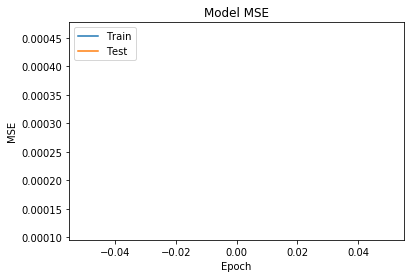

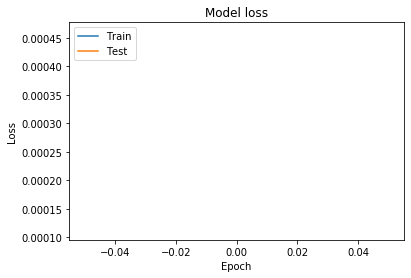

In [12]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline
history = trainer.history
def plotHistory():
    # Plot training & validation accuracy values
    plt.plot(history['mse'])
    plt.plot(history['val_mse'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plotHistory()

In [13]:
model = trainer.model
pred = None
label = None
pred_ = 20
test.on_epoch_end()
mean = []
stdev = []
label = []
prediction = []
for x,y in train:
    for i in range(batch_size):
        if y[i,:,:,:].max() > 0:
            pred = model(np.array([x[i,:,:,:]]))
            prediction.append(pred)
            #mean.append(pred.mean())
            #stdev.append(pred.stddev())
            label.append(y[i,:,:,:])
    if len(label) >= pred_:
        break
        


/home/simon/Dokumente/Teamprojekt/DeepRain2/Networks/Utils/transform.py:120: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return img[self.slices]


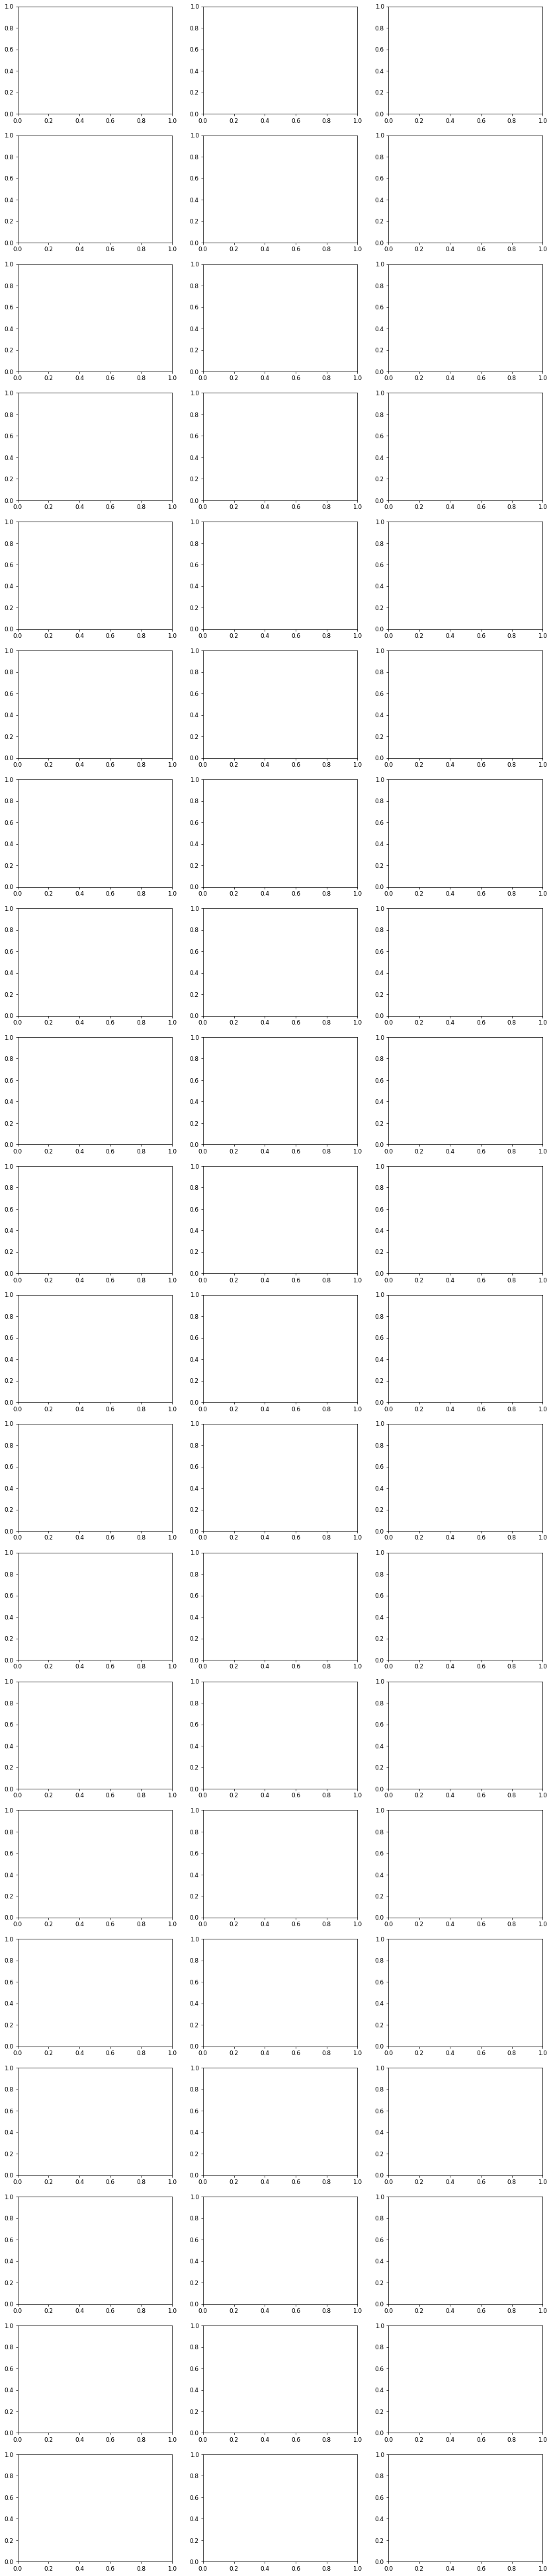

In [14]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline
fig, axes = plt.subplots(20, 3, figsize=(16,8*10),dpi=64)
#fig.set_title(["mean","stdev","label"])
for batch,img in enumerate(mean):
    if batch == 20:
        break
    #axes[batch,0].imshow(stdev[batch][0,:,:,0],cmap="gray")
    axes[batch,1].imshow(pred[0,:,:,0],cmap="gray")
    axes[batch,2].imshow(label[batch][:,:,0],cmap="gray")

In [ ]:
def map_Dist_To_Rain(prediction,label):
    
    x,y,t      = prediction[0][0,:,:,:].shape
    rain_true  = np.zeros((x,y,t))
    rain_false = rain_true.copy()
    
    
    
    ones = np.ones((x,y))
    zeros = np.zeros((x,y,t))
    value_map = np.array([ones * i/255 for i in range(256)])
    value_map = value_map.transpose(1,2,0)
    for i,pred in enumerate(prediction):
        ones = np.ones((x,y,t)) * 3/255
        #print((np.array(pred.prob(ones))).max(axis=-1) )
        probs = np.array(pred.prob(value_map))
        print(label[i].max())
        max_probs = probs.argmax(axis=-1)
        #print(probs[0,1,1,:].argmax())

        #print(probs.argmax(axis=-1))
        #print(probs.max(axis=-1))
        for j in range(64):
            for k in range(64):
                at = np.argmax(probs[0,k,j,:])
                if at > 0:
                #at = probs[0,k,j,:] .sum()
                    print("AATT",at)
        #    print(j,"min:",probs[:,:,:,j].min(),"max:",probs[:,:,:,j].max())
        #print(probs.shape)
        #print(probs)
        #print(pred.prob(0.0))
        print(np.array(pred.prob(label[i].max())).max() )
        print(np.array(pred.prob(label[i].max())).min() )
        if label[i].max() == 0:
            continue

        print(pred)
        s = (1-pred.cdf(zeros))
        
        #print(np.array(s).max(),np.array(probs.mean()).max(),label[i].max())
        
        plt.imshow(max_probs[0,:,:],cmap="gray")
        plt.show()
        plt.imshow(s[0,:,:,0],cmap="gray")
        plt.show()
        plt.imshow(label[i][:,:,0],cmap="gray")
        plt.show()
        break
    

#map_Dist_To_Rain(prediction,label)
print(prediction[0])

In [ ]:
a = np.arange(10)
ind = 5
lab = label[ind]
print(lab.max())
idx = np.where(lab == lab.max() )
pred = prediction[ind]
#for i in range(512):
#    a = np.ones((64,64,1)) * i/255
    #print(i,np.array(pred.prob(a)).max() )
#print(np.array(pred.mean())[33,28])
y = []
x = []
for i in range(10):
    x.append(10)
    y.append(np.array(pred.prob(i))[0,idx[0],idx[1],0][0])
print(np.array(pred.mean())[0,idx[0],idx[1],0][0])

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(20,8.27)})
sns.barplot(x,y)
plt.show()
plt.imshow(lab[:,:,0])
plt.show()

plt.imshow(pred.mean()[0,:,:,0])
plt.show()
print(np.array(pred.sample()).max(),lab.max())
plt.imshow(np.array(pred.prob(lab))[0,:,:,0])